<a href="https://colab.research.google.com/github/gabbycjames/DataScience_Capstone/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Desert Investigation -- Modeling

## Imports

In [13]:
import os
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go

## Data

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#%cd drive/My Drive/ColabNotebooks/(DataScience_Capstone/Modeling.i)

In [16]:
df = pd.read_csv('/content/drive/MyDrive/DataScience_Capstone/scaled_data.csv')

In [17]:
df.head()

,FIPS,CACFP_PART_2016,CONVS16,FFR16,FSR16,GROC16,NSLP_PART_2016,PCT_WICINFANTCHILD16,PCT_WICWOMEN16,RECFAC16,...,Asian,Latino,HS_GED,Bachelors,Employed,Unemployed,Midwest,Northeast,South,West
0,-1.939205,-0.45354,-0.096774,-0.118123,-0.176332,-0.197530,-0.398,1.35391,0.898924,-0.130226,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
1,-1.939073,-0.45354,0.799750,0.298354,0.582731,0.090641,-0.398,1.35391,0.898924,0.275224,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
2,-1.938941,-0.45354,-0.220432,-0.196213,-0.239279,-0.186447,-0.398,1.35391,0.898924,-0.292406,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
3,-1.938809,-0.45354,-0.261652,-0.255709,-0.265198,-0.175363,-0.398,1.35391,0.898924,-0.265376,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
4,-1.938677,-0.45354,-0.137993,-0.196213,-0.246684,-0.175363,-0.398,1.35391,0.898924,-0.184286,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414


In [18]:
#fig = plt.figure(0)
#plt.grid(True)
#plt.title("Plot of scaled data")
#plt.scatter(X[:,0],X[:,1])
#plt.show()

## K-Means

In [39]:
from sklearn.cluster import KMeans

In [40]:
import sklearn
sklearn.show_versions()


System:
    python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.85+-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.5.2
          pip: 24.1.2
   setuptools: 71.0.4
        numpy: 1.26.4
        scipy: 1.13.1
       Cython: 3.0.11
       pandas: 2.2.2
   matplotlib: 3.7.1
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 2
         prefix: libopenblas
       filepath: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: Haswell

       user_api: blas
   internal_api: openblas
    num_threads: 2
         prefix: libopenblas
       filepath: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: Haswell

       user

### Choosing Number of Clusters
**Elbow Method**

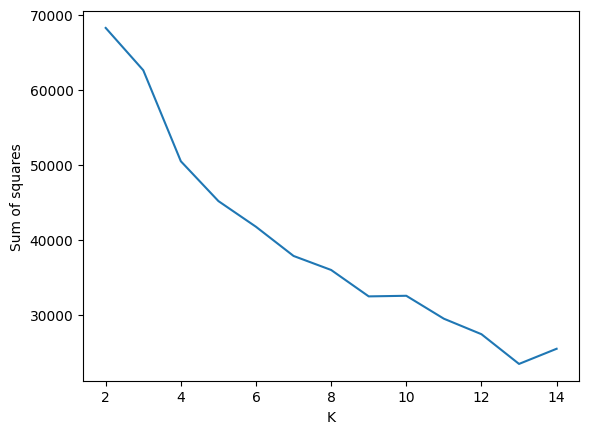

In [41]:
ss = []
possible_k = {}
Krange = list(range(2,15))
X = df.to_numpy()

for i in Krange:
    model = KMeans(n_clusters=i)
    current_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[current_cluster])**2))
    possible_k[str(i)] = current_cluster

plt.plot(Krange,ss)
plt.xlabel("K")
plt.ylabel("Sum of squares")
plt.show()


**Choosing K:** By using the elbow method, it looks like 8 is a good value for K. My goal is to minimize the sum of squares, without getting too large of a value for K.

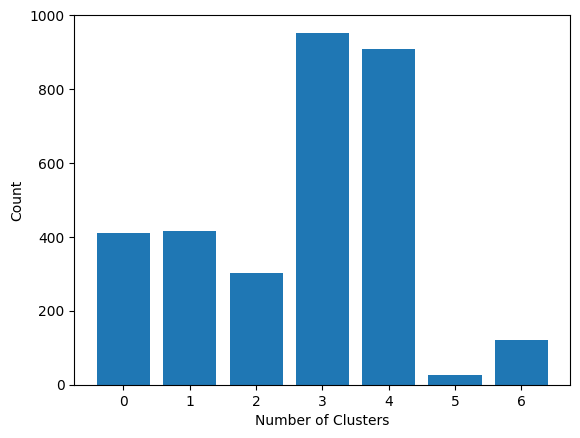

In [42]:
K = 7
best_K = possible_k[str(K)]
count = np.bincount(best_K)
_ = plt.bar(range(K), height=count, align='center')
_ = plt.xlabel('Number of Clusters')
_ = plt.ylabel('Count')
_ = plt.show()

**Silhouette Scores**

For n_clusters =  2 the average silhouette score is:  0.5502071821596443
For n_clusters =  3 the average silhouette score is:  0.5358776474190535
For n_clusters =  4 the average silhouette score is:  0.22671248578456898
For n_clusters =  5 the average silhouette score is:  0.2587423116110895
For n_clusters =  6 the average silhouette score is:  0.2858940107804763
For n_clusters =  7 the average silhouette score is:  0.30094706928104503
For n_clusters =  8 the average silhouette score is:  0.3182067455423621
For n_clusters =  9 the average silhouette score is:  0.31405678430746187
For n_clusters =  10 the average silhouette score is:  0.32300702034498324
For n_clusters =  11 the average silhouette score is:  0.32006717176581756
For n_clusters =  12 the average silhouette score is:  0.35487272829144406
For n_clusters =  13 the average silhouette score is:  0.3761339036734593
For n_clusters =  14 the average silhouette score is:  0.35362712492149


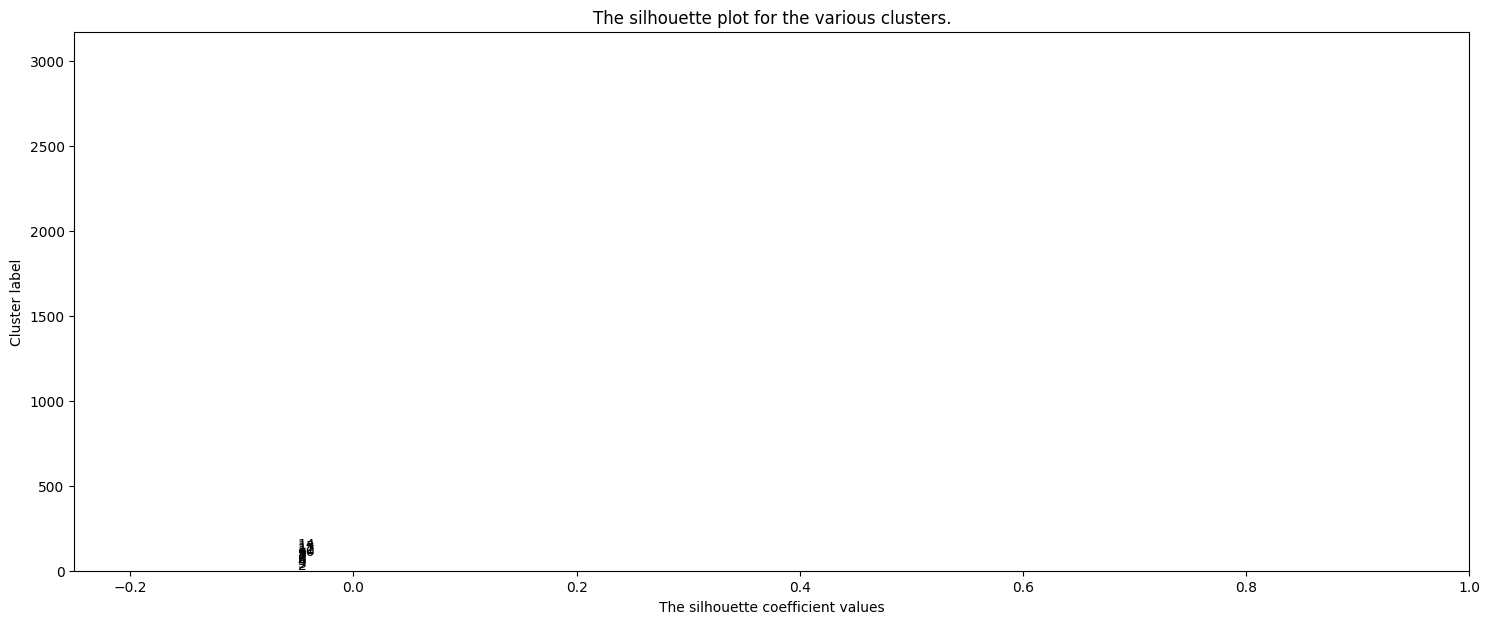

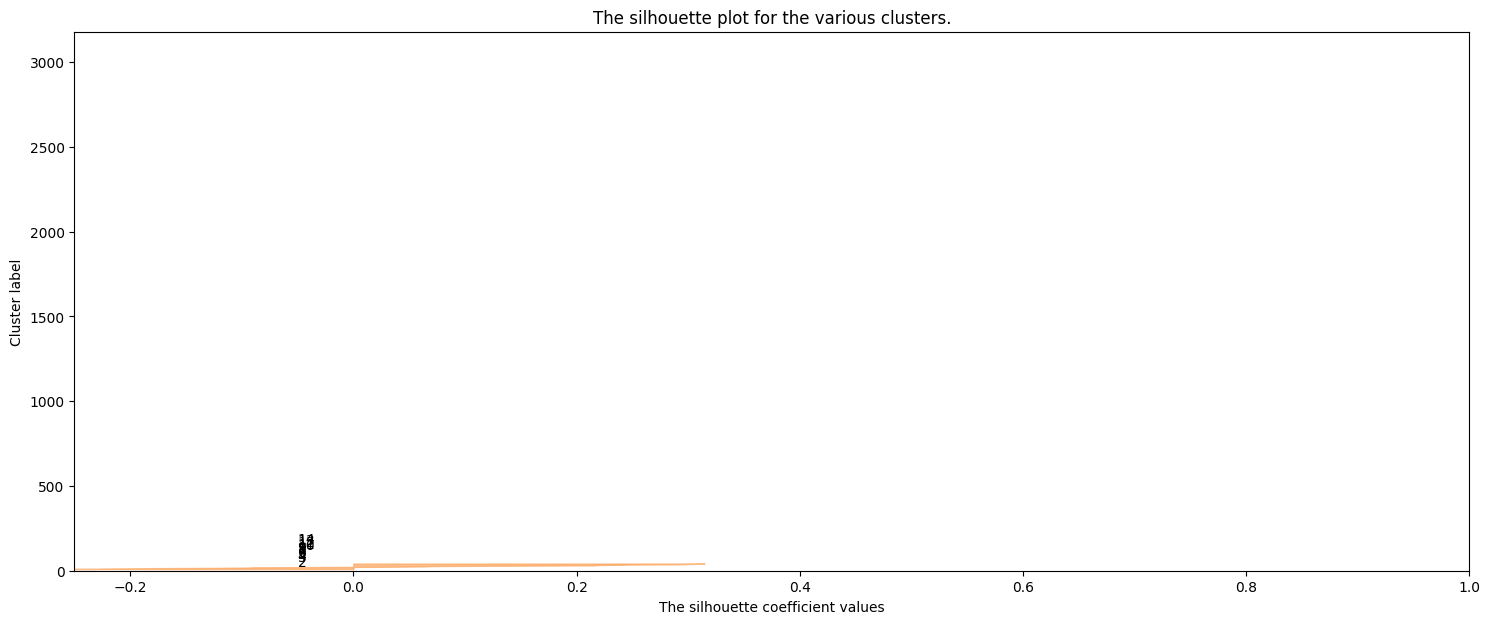

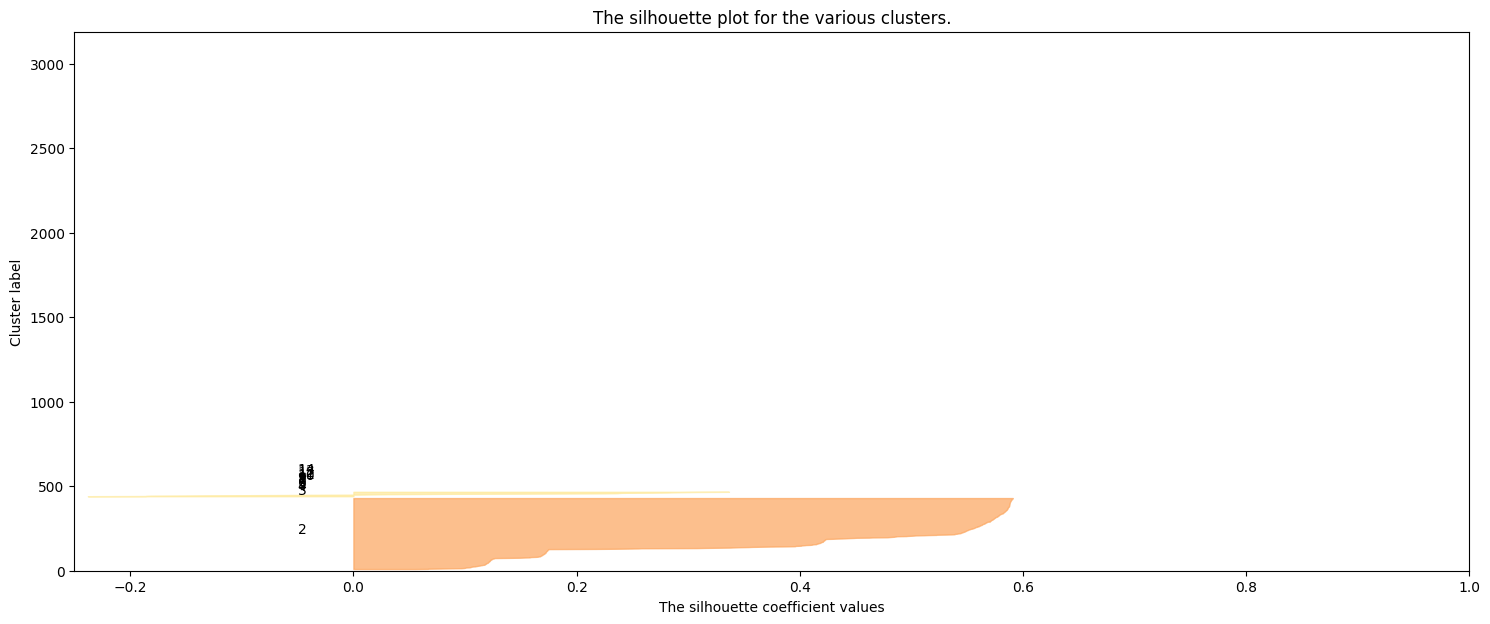

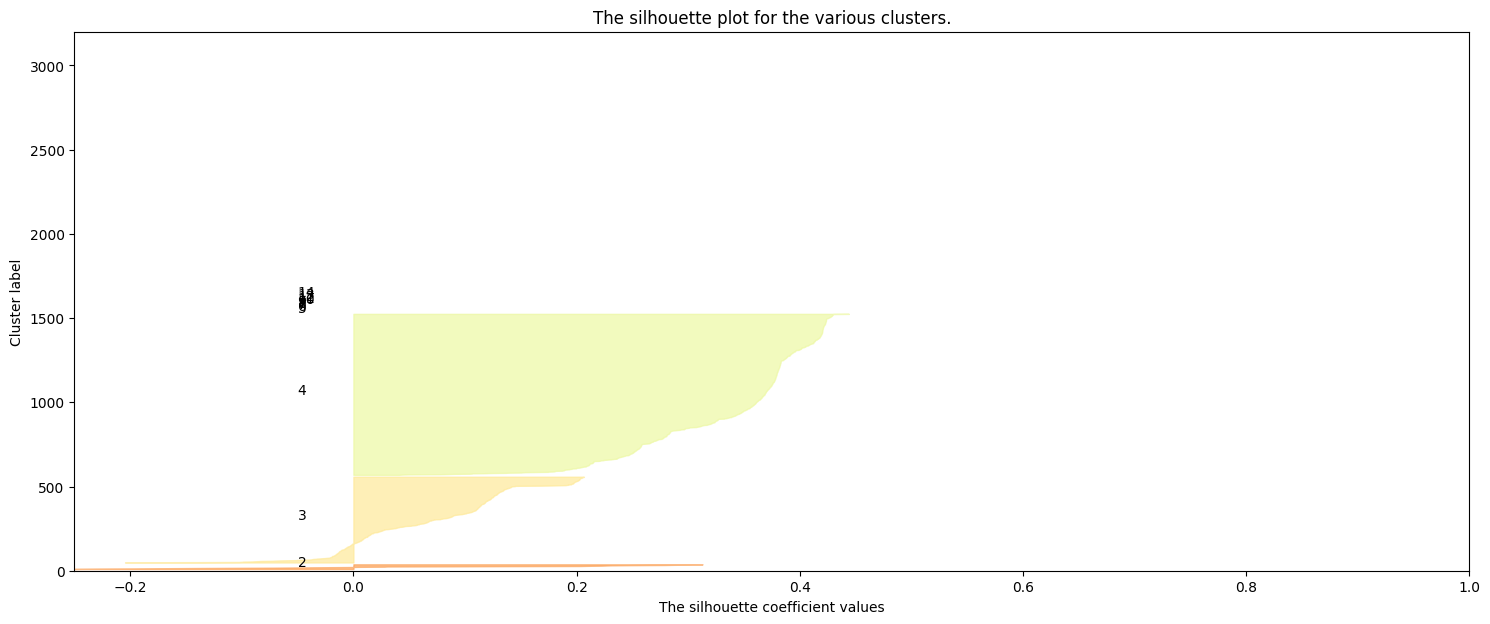

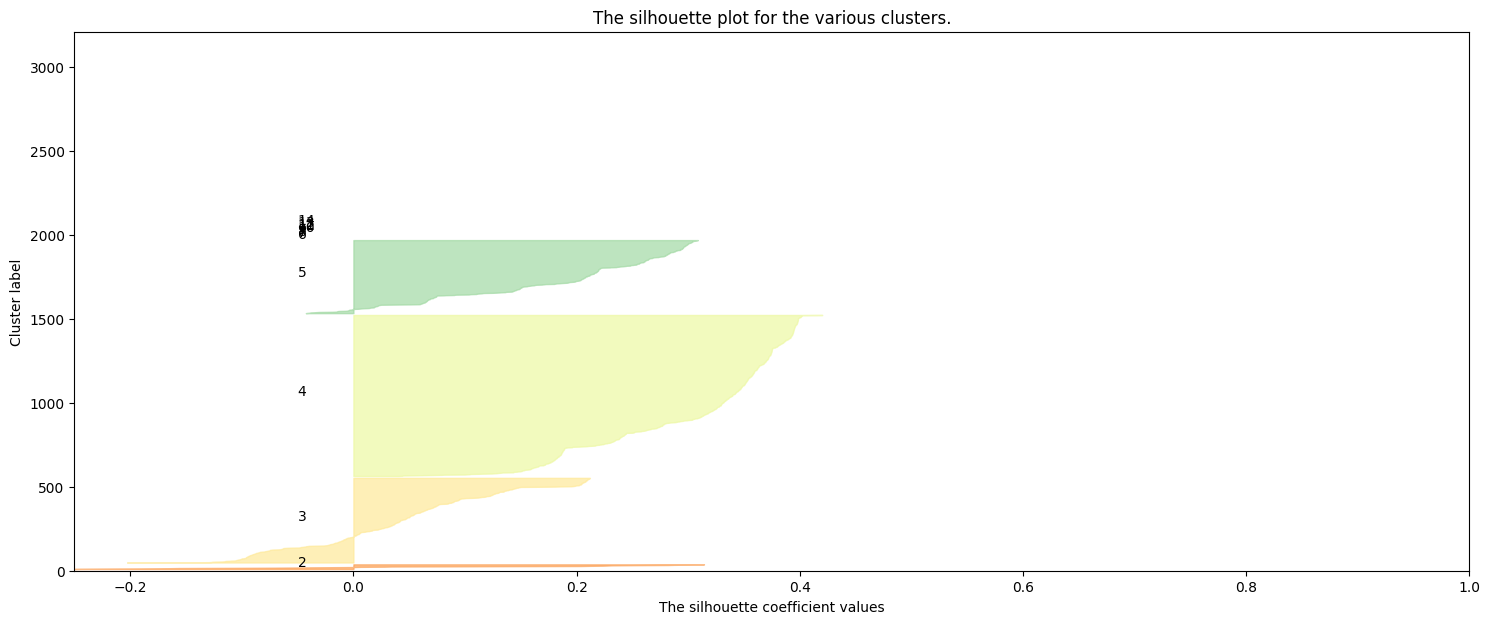

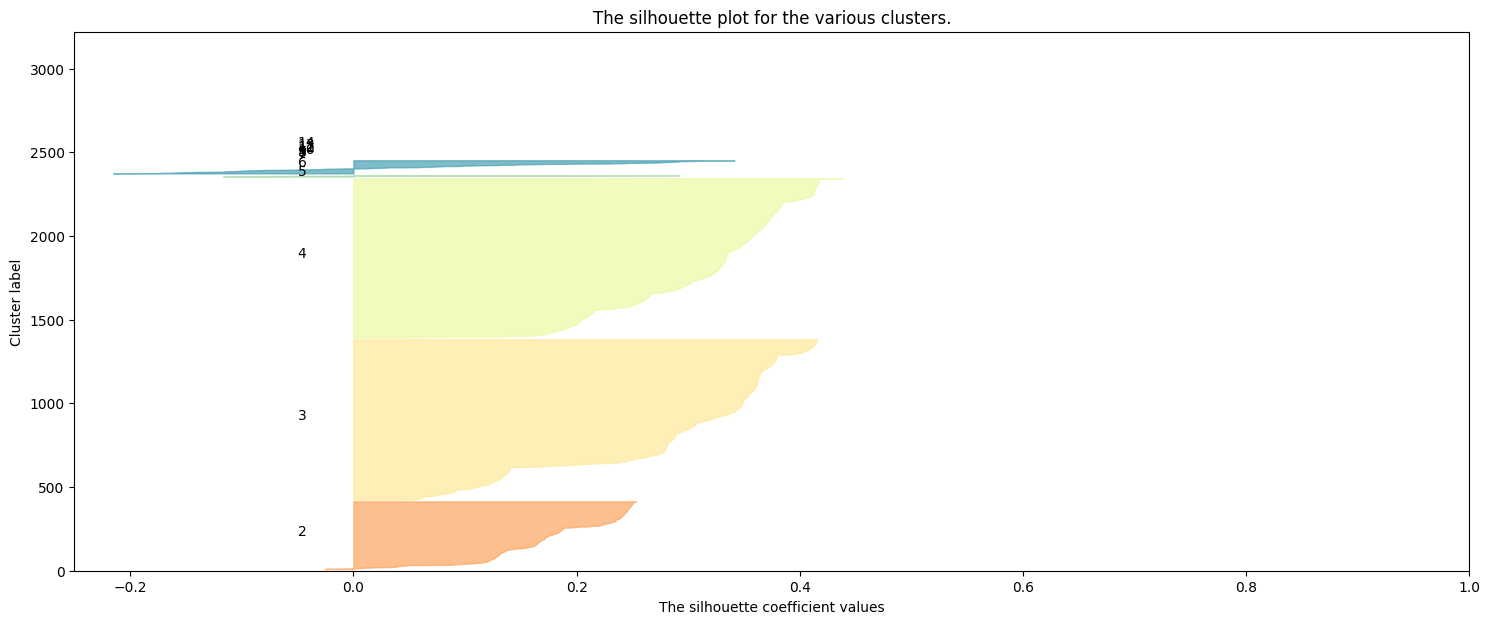

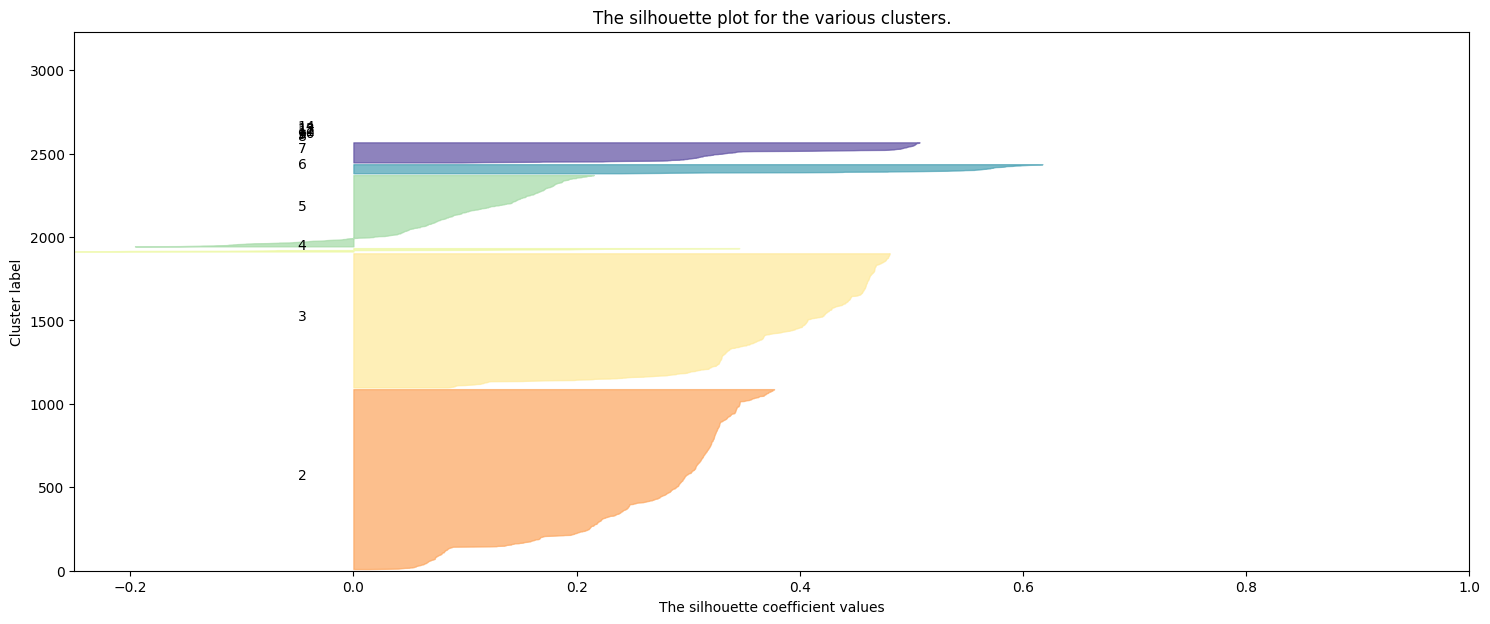

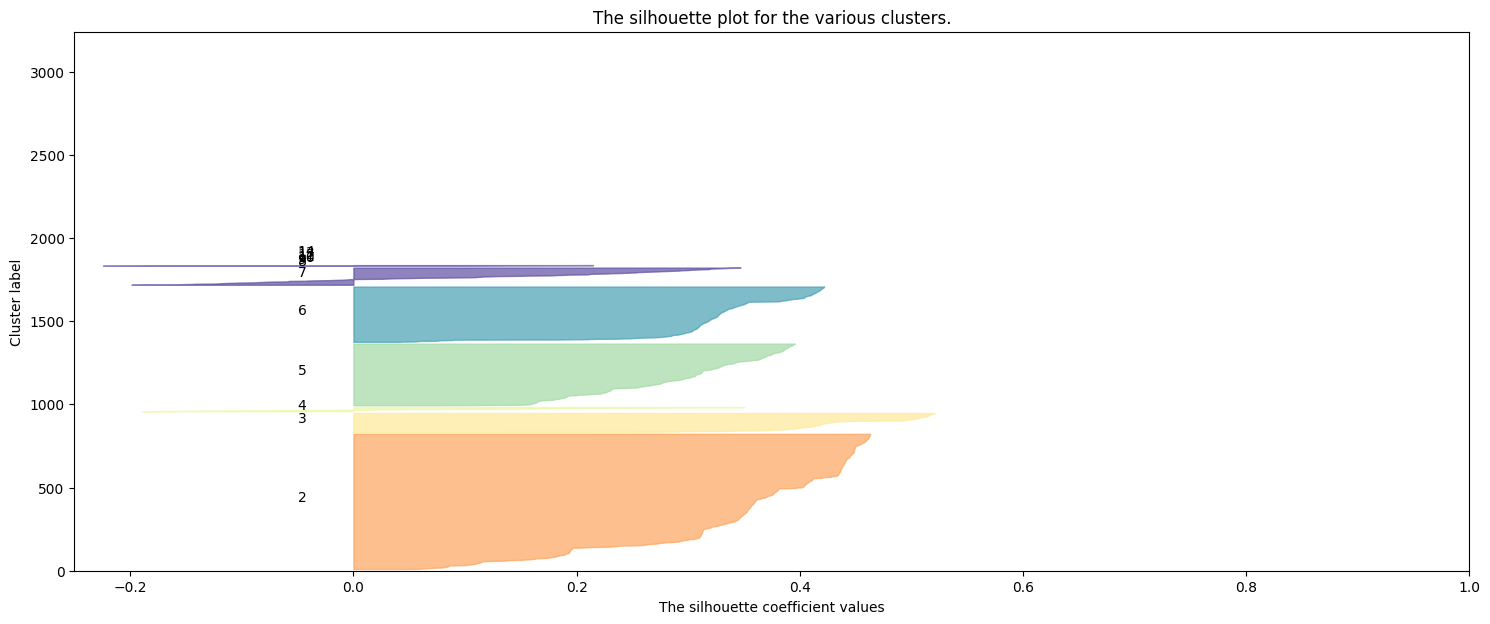

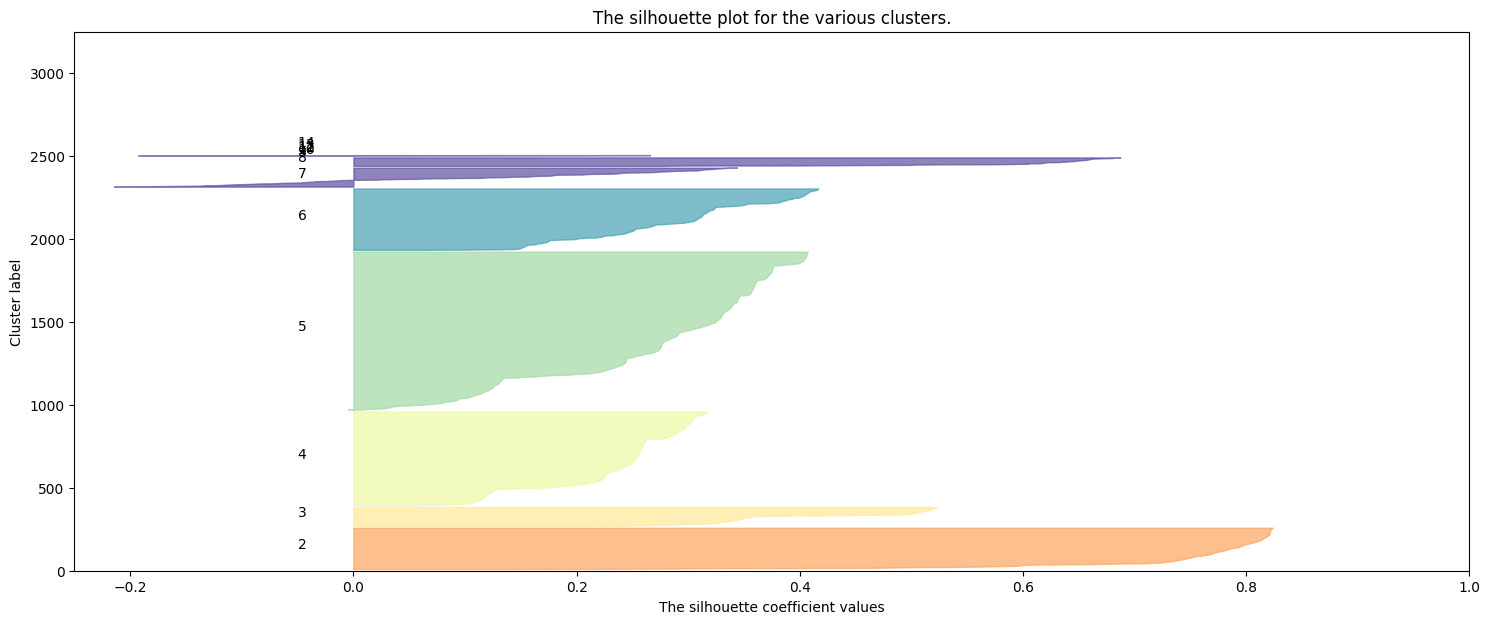

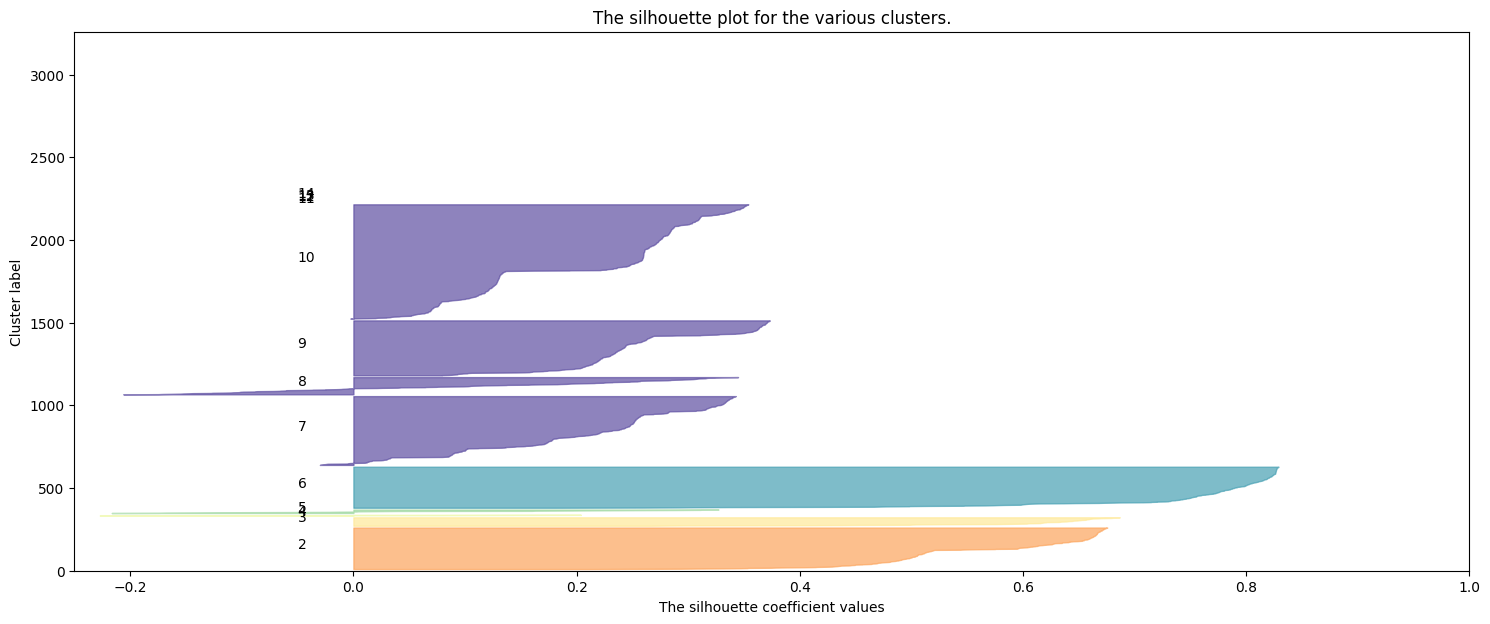

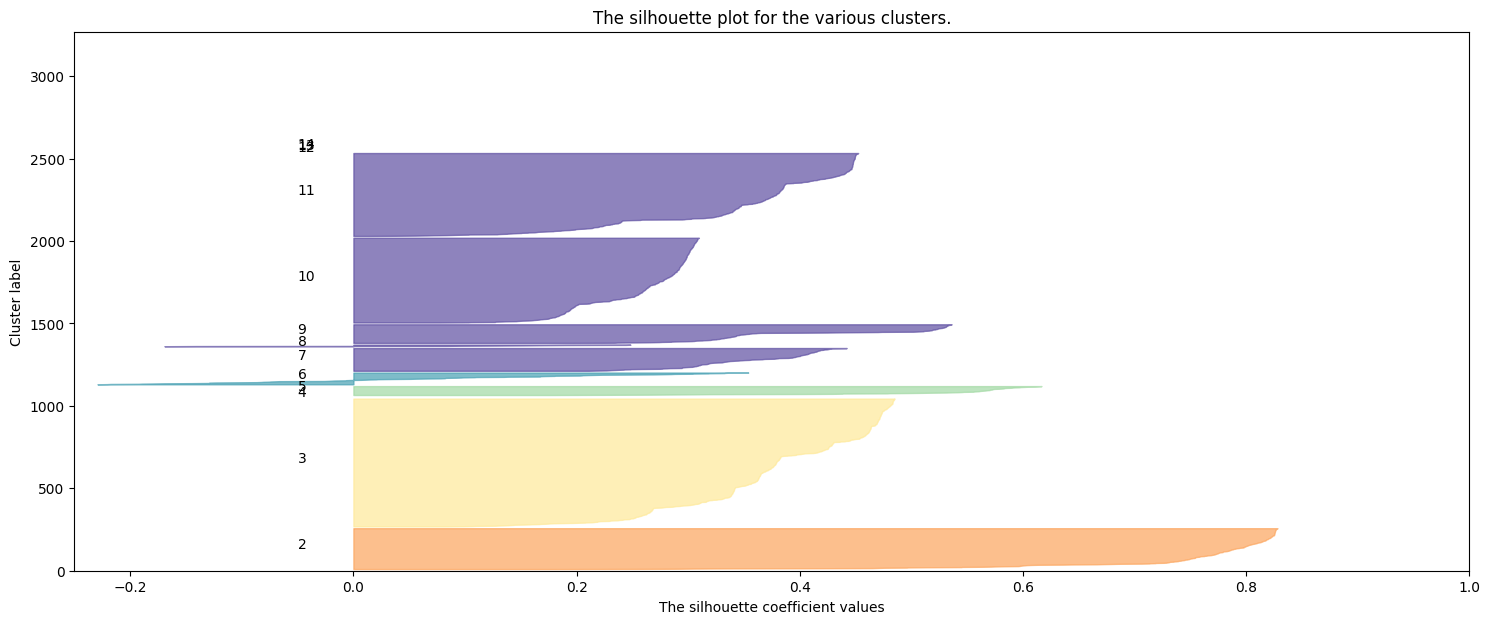

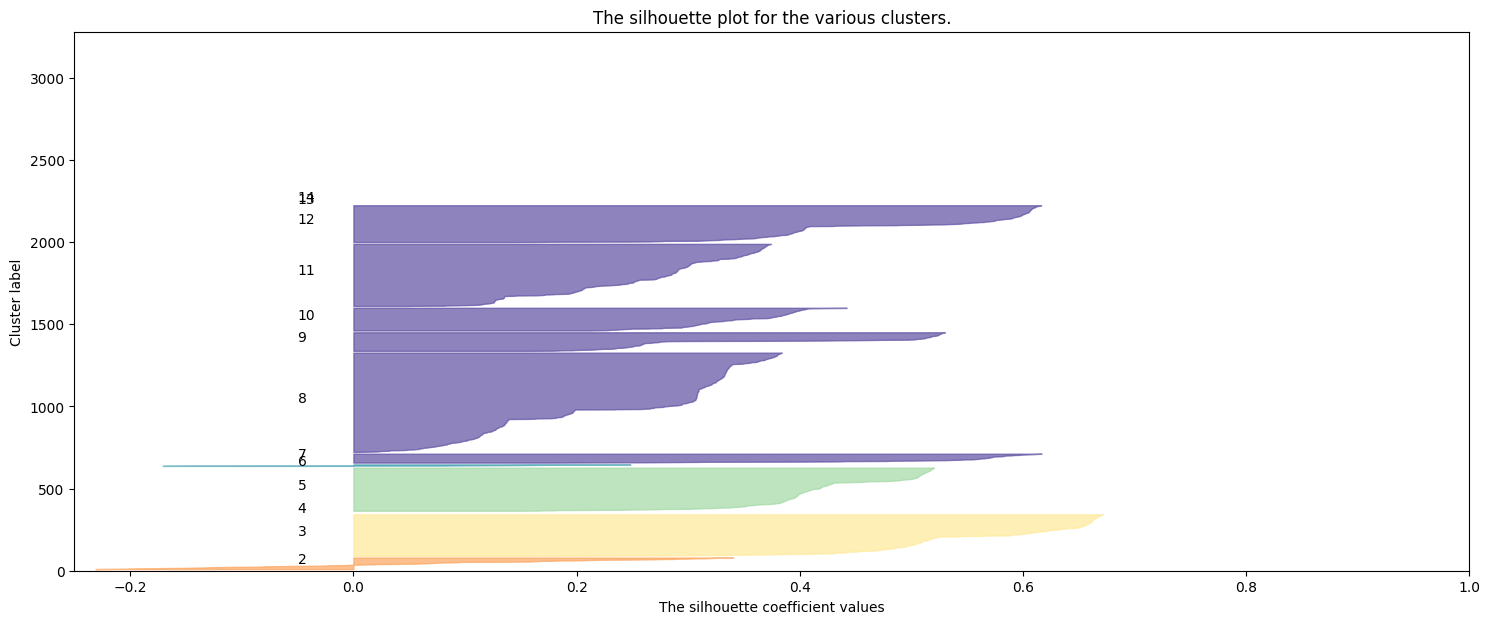

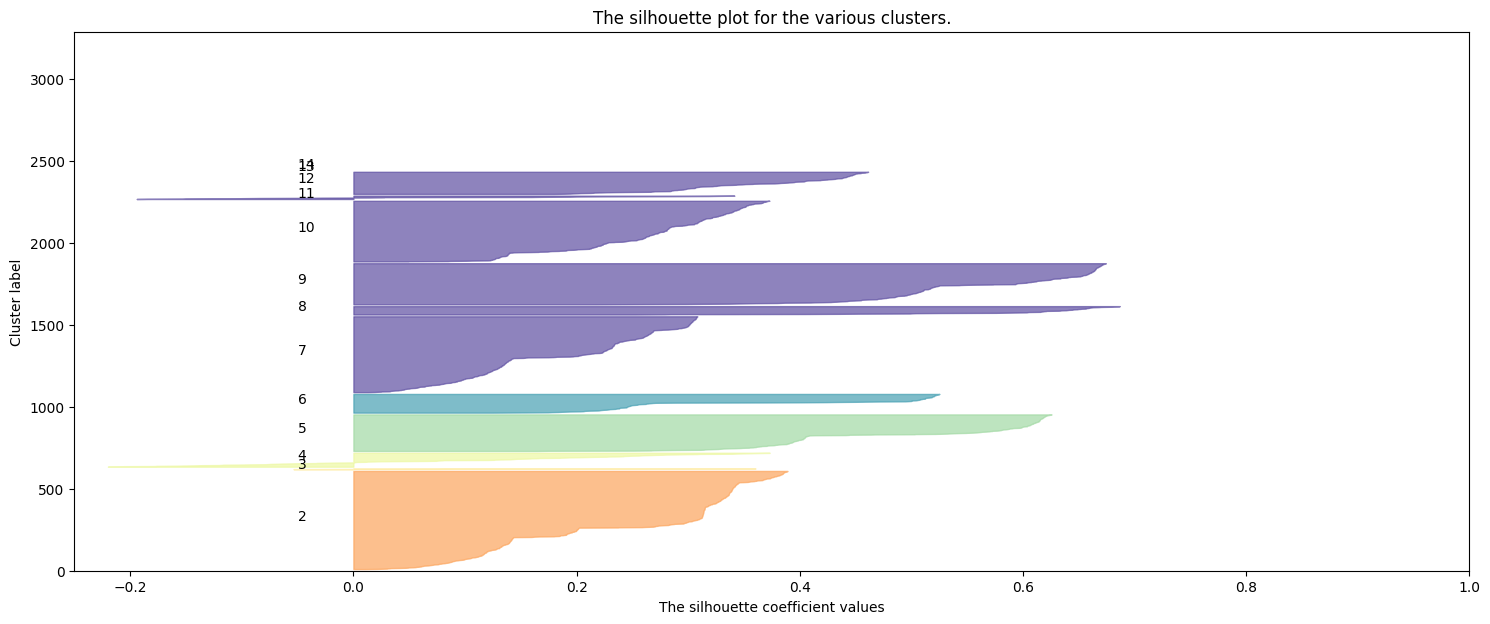

In [43]:
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import colormaps
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

avg_silhouette_scores = []

for n_clusters in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.25, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in Krange:
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        y_upper = y_lower + size_cluster_i


        cmap = mpl.colormaps.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")


    print("For n_clusters = ", n_clusters, "the average silhouette score is: ", silhouette_avg)

**PCA**

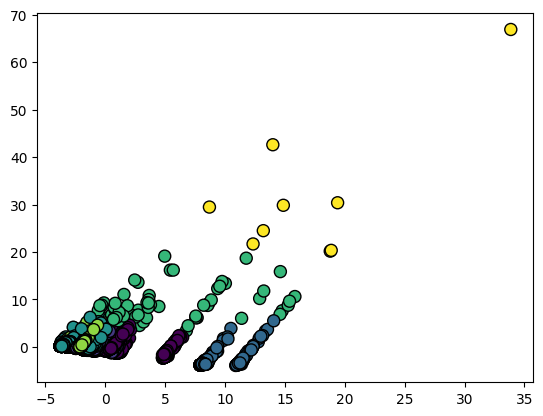

In [47]:
from sklearn.decomposition import PCA
import matplotlib.colors

model = sklearn.cluster.KMeans(n_clusters=7, n_init=10)
cluster_assignment = model.fit_predict(X)

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1,pc2,edgecolors='k',c=cluster_assignment.tolist(),s=75)

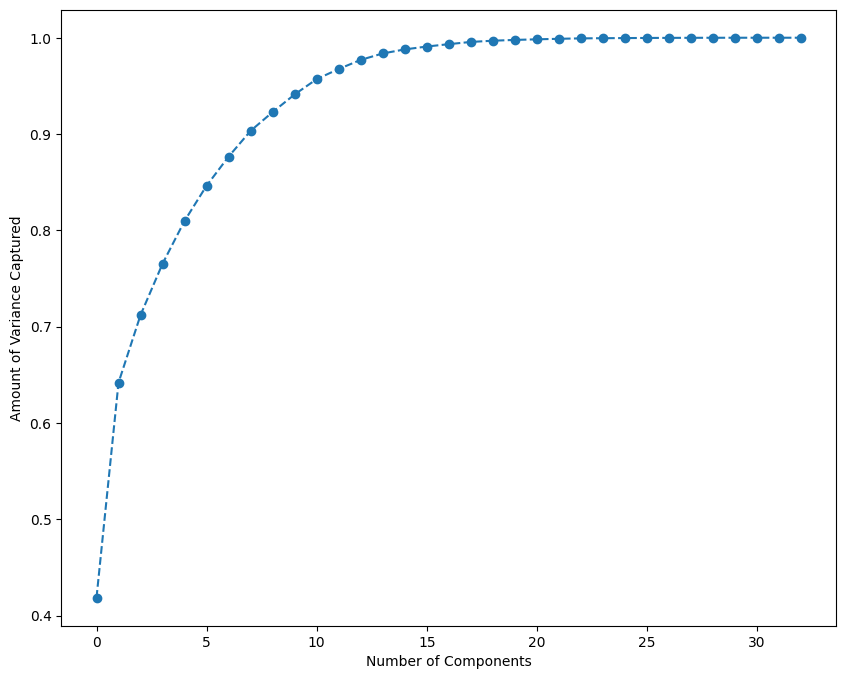

In [45]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
variance = pca.explained_variance_ratio_
plt.figure(figsize = (10,8))
plt.plot(variance.cumsum(), marker='o', linestyle='--')
plt.ylabel("Amount of Variance Captured")
plt.xlabel("Number of Components")
plt.show()

## Affinity Propagation

**Imports**

In [32]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

**Affinity Propagation**

In [33]:
from sklearn.cluster import AffinityPropagation
affinity = AffinityPropagation(random_state=42)
affinity.fit(X)
labels= affinity.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [34]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Silhouette Coefficient: 0.541


In [35]:
cluster_centers_indices = affinity.cluster_centers_indices_
labels = affinity.labels_

n_clusters_ = len(cluster_centers_indices)

In [36]:
print("Number of clusters detected by Affinity Propagation: ", n_clusters_)

Number of clusters detected by Affinity Propagation:  443


In [37]:
print("Cluster centers detected at: \n\n", X[cluster_centers_indices])

Cluster centers detected at: 

 [[-1.93709338 -0.45353994  0.04749431 ... -0.27246797  1.09916219
  -0.40741366]
 [-1.86470305 -0.77292992 -0.38531041 ... -0.27246797 -0.90978384
   2.45450779]
 [-1.74044509 -0.5623304   9.57950314 ... -0.27246797 -0.90978384
   2.45450779]
 ...
 [ 1.6244843  -0.44039807 -0.17921292 ... -0.27246797 -0.90978384
  -0.40741366]
 [ 1.62936751 -0.44039807  3.04621277 ... -0.27246797 -0.90978384
  -0.40741366]
 [ 1.6920574  -0.789131   -0.28226167 ... -0.27246797 -0.90978384
   2.45450779]]


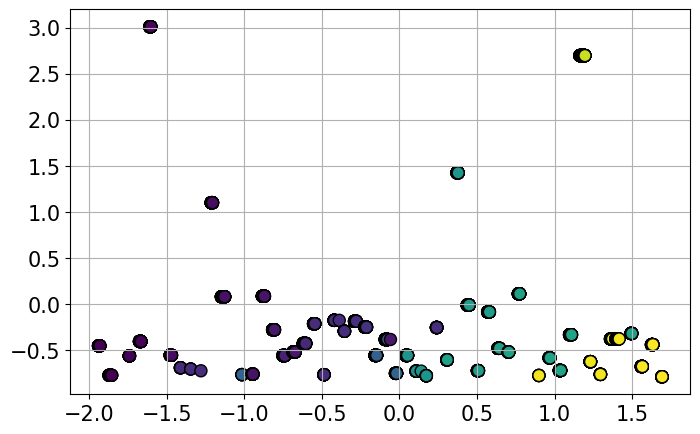

In [38]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],edgecolors='k',c=affinity.labels_,s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()